In [1]:
import sys
import os
import toml

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
import json
import scipy.optimize as SciOpt
from scipy.special import rel_entr
from tqdm.notebook import tqdm
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
# mpl.rcParams["font.family"] = 'serif'
# mpl.rc('text', usetex=True)
# plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update(
    {
        # "text.usetex": True,
        "text.latex.preamble": r"\usepackage{bm}",
        # Enforce default LaTeX font.
        "font.family": "serif",
        "mathtext.fontset": "dejavuserif",
    }
)

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from data.data_generators import DataGenerator
from lsm.lsmtype import Policy
import lsm.cost as CostFunc
import lsm.solver as Solvers

In [2]:
config = Reader.read_config('../../endure.toml')
data_gen = DataGenerator(config)
wls = config['workloads']

In [3]:
VIZ_DIR = '/Users/ndhuynh/sandbox/viz'
RHO = 1
ROBUST_DF = pd.read_csv('/Users/ndhuynh/sandbox/data/workload_uncertainty_tunings.csv')

In [4]:
def get_nominal_tunings(workload):
    tunings = {model: get_nominal_tuning(workload, model=model) for model in models}
    return tunings

def get_nominal_tuning(workload, model='K'):
    solvers = {
        '1-Level': Solvers.EndureOneLevelingSolver,
        'Robust': Solvers.EndureLevelSolver,
        'Dostoevsky': Solvers.EndureDostoevskyFixedSolver,
        'Lazy Level': Solvers.EndureLazyLevelingSolver,
        'Y1': Solvers.EndureYSolver,
        'FluidLSM': Solvers.EndureYZSolver,
        'Q': Solvers.EndureQSolver,
        'K-LSM': Solvers.EndureKSolver,
        'Tier': Solvers.EndureTierSolver,
        'Nominal': Solvers.EndureLevelSolver,
        'Level': Solvers.EndureLevelSolver}
    z0, z1, q, w = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    solver = solvers.get(model, None)
    if solver is None:
        print('Invalid model')
        return None
    solver = solver(config)
    if model == 'Robust':
        # g = ROBUST_DF.groupby('workload_idx').get_group(workload['id'])
        # x = g[g.rho == RHO][['robust_m_h', 'robust_T']].values[0]
        # design = x
        level_solver = solvers.get('Level')(config)
        level_design = level_solver.find_robust_design(RHO, z0, z1, q, w)
        tier_solver = solvers.get('Tier')(config)
        tier_design = tier_solver.find_robust_design(RHO, z0, z1, q, w)
        solver = tier_solver
        design = tier_design.x[:-2]
        if level_design.fun < tier_design.fun:
            solver = level_solver
            design = level_design.x[:-2]
        # design = solver.find_robust_design(RHO, z0, z1, q, w)
        # print(f'{model}: {design.message}')
        # design = design.x[:-2] # Remove lagrangian variables lambda eta
    elif model == 'Nominal':
        # g = ROBUST_DF.groupby('workload_idx').get_group(workload['id'])
        # x = g[g.rho == RHO][['nominal_m_h', 'nominal_T']].values[0]
        # design = x
        
        level_solver = solvers.get('Level')(config)
        level_design = level_solver.find_nominal_design(z0, z1, q, w)
        tier_solver = solvers.get('Tier')(config)
        tier_design = tier_solver.find_nominal_design(z0, z1, q, w)
        solver = tier_solver
        design = tier_design.x
        if level_design.fun < tier_design.fun:
            solver = level_solver
            design = level_design.x
    else:
        design = solver.find_nominal_design(z0, z1, q, w)
        # print(f'{model}: {design.message}')
        design = design.x
    tuning = {'design': design, 'solver': solver}
    return tuning

In [5]:
def set_style(fsz=14):
    mpl.rcParams["font.size"] = f'{fsz}'
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def sample_workloads(samples=10000):
    wls = []
    np.random.seed(0)
    for _ in range(samples):
        wls.append(data_gen._sample_workload(4))
    return wls

def kl_div(w0: np.array, w1: np.array):
    return np.sum(rel_entr(w0, w1))

In [6]:
def gen_workloads(w0: np.array) -> pd.DataFrame:
    w0 = np.array([w0[key] for key in ('z0', 'z1', 'q', 'w')])
    samples = sample_workloads()
    distances = []
    for sample in samples:
        distances.append(
            {'workload': sample,
             'rho': kl_div(sample, w0)})
        
    return pd.DataFrame(distances)

In [7]:
def eval_nominal(model, desc, z0, z1, q, w):
    x, s = desc['design'], desc['solver']
    if model == 'Dostoevsky':
        x = np.around(x)
    else:
        x = np.concatenate([[x[0]], np.around(x[1:])])
    return s.nominal_objective(x, z0, z1, q, w)

In [8]:
def gen_costs(
    w0: dict[str, float],
    workloads: list[list[float]],
    tunings: dict[str, dict]
) -> pd.DataFrame:
    df = []
    w0 = np.array([w0[key] for key in ('z0', 'z1', 'q', 'w')])
    for wl in workloads:
        z0, z1, q, w = wl
        row = {'rho': kl_div(wl, w0), 'z0': z0, 'z1': z1, 'q': q, 'w': w}
        for key, val in tunings.items():
            row[key] = eval_nominal(key, val, z0, z1, q, w)
        df.append(row)
    # Special case we will add our orignal workload
    z0, z1, q, w = w0
    row = {'rho': 0, 'z0': z0, 'z1': z1, 'q': q, 'w': w}
    for model_name, desc in tunings.items():
        row[model_name] = eval_nominal(model_name, desc, z0, z1, q, w)
    df.append(row)
    return pd.DataFrame(df)

In [9]:
def set_size(fig, width=3.33, height=2, scale=1):
    fig.set_size_inches(width * scale, height * scale)
    plt.tight_layout()
    
def save_fig(fig, filename):
    fig.savefig(os.path.join(VIZ_DIR, filename), dpi=300, format='pdf', bbox_inches='tight')

In [32]:
def create_and_plot(workload, samples, plot_error=False):
    tunings = {model: get_nominal_tuning(workload, model) for model in models}
    # for t in tunings.items():
    #     print(t)
    df = gen_costs(workload, samples, tunings)
    
    rho_bins = np.arange(0.0, 4.5, 0.3)
    rho_bins = list(zip(rho_bins, rho_bins[1:]))
    rhos = np.array([0] + [x + (y - x) / 2 for x, y in rho_bins])

    mean = []
    for low, high in rho_bins:
        mean.append(df[(df.rho > low) & (df.rho <= high)].mean().to_dict())
    mean = pd.DataFrame([df.iloc[-1].to_dict()] + mean)
    
    std = []
    for low, high in rho_bins:
        std.append(df[(df.rho > low) & (df.rho <= high)].std().to_dict())
    std = pd.DataFrame([df.iloc[-1].to_dict()] + std)
    
    fig, ax = plt.subplots()
    for model in tunings.keys():
        ax.plot(rhos,
                mean[model],
                label=f'{model}',
                marker=markers[model],
                color=colors[model],
                linestyle='dashed' if model == 'Robust' else 'solid')
        if plot_error:
            ax.fill_between(mean['rho'], mean[model] - std[model], mean[model] + std[model], alpha=0.2, color=colors.get(model, 'black'))
            
    wl_id = workload['id']
    w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    xlabel_str = f'$I_{{KL}}( \hat{{w}}, w_{{{wl_id}}})$'
    if wl_id == 11:
        title_str = 'Read-Heavy | '
    else:
        title_str = 'Mixed Read-Write | '
    title_str += f'$w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})'
    ax.set_xlabel(xlabel_str)
    ax.set_title(title_str)
    ax.set_ylabel(r'Avg. I/O Per Query')
    _ = ax.legend(borderpad=0.3, labelspacing=0.2, ncol=2, columnspacing=0.5, frameon=True).set_zorder(2)
    
    return df, tunings, fig, ax

In [33]:
samples = sample_workloads()

In [34]:
models = ['Robust', 'Nominal', 'Lazy Level', 'Dostoevsky', 'FluidLSM', 'K-LSM']
markers = ['*', 'o', '+', 'd', 'x', '1']
markers = {model: marker for model, marker in zip(models, markers)}
colors = ['tab:green', 'tab:gray', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:cyan']
colors = {model: color for model, color in zip(models, colors)}

Robust : [1.         3.83647886]
Nominal : [ 7.97593624 10.85263015]
Lazy Level : [ 4.44863449 11.38749261]
Dostoevsky : [13.2578225 12.2032169  1.       ]
FluidLSM : [ 6.44389883 13.20894423 10.57179284  1.18323488]
K-LSM : [ 6.5785838  13.37996961 12.30810309 12.22588995 11.2643917   1.
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.        ]


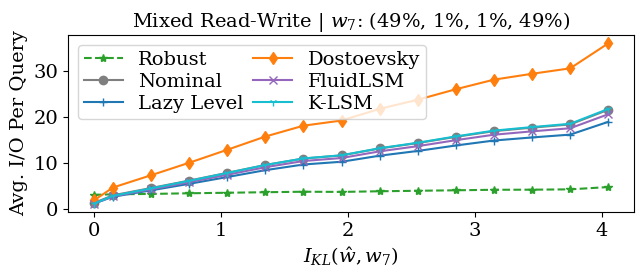

In [35]:
set_style(fsz=14)
df, tunings, fig, ax = create_and_plot(wls[7], samples, plot_error=False)
ax.set_xticks([0, 1, 2, 3, 4])
set_size(fig, width=2*3.33, height=1.5*2)
save_fig(fig, 'w7_distance_cost.pdf')
for key, desc in tunings.items():
    print(f'{key} : {desc["design"]}')

Robust : [ 1.         11.64687675]
Nominal : [ 4.46648108 47.44506362]
Lazy Level : [4.65364362 2.        ]
Dostoevsky : [46.53021791  1.          1.        ]
FluidLSM : [ 4.46648133 47.4448439   1.          1.        ]
K-LSM : [ 4.46647958 47.44528077  1.          1.          1.0596703   1.0102404
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.        ]


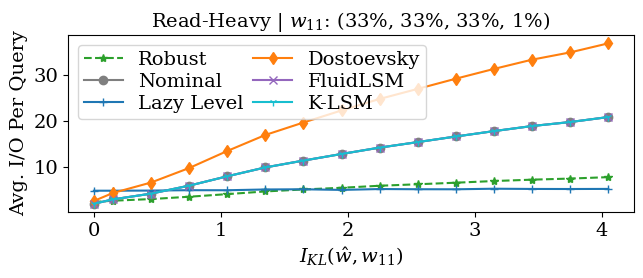

In [36]:
set_style(fsz=14)
df, tunings, fig, ax = create_and_plot(wls[11], samples, plot_error=False)
# ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 1, 2, 3, 4])
set_size(fig, width=2*3.33, height=1.5*2)
save_fig(fig, 'w11_distance_cost.pdf')
for key, desc in tunings.items():
    print(f'{key} : {desc["design"]}')

Hypothesis

H1: Flexible cost models provide best nominal performance (>=)

    - Only point read queries -> "True"
    - Write queries introdued -> True
    - Range queries introduced -> False

H2: Flexible cost models are inherently more robust

    - Only point read queries -> "False"
    - Write queries introdued -> False
    - Range queries introduced -> True

In [15]:
# def plot_rw_graph(workload, samples, model='K'):
#     tuning = get_nominal_tuning(workload, model)
#     rw = [sum([sample[0], sample[1], sample[3]]) for sample in samples]
#     w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
#     wl_id = workload['id']
#     rhos = [kl_div(sample, w0) for sample in samples]
#     cost = [tuning['solver'].nominal_objective(tuning['design'], sample[0], sample[1], sample[2], sample[3]) for sample in samples]

#     fig, ax = plt.subplots()
#     cmap = plt.get_cmap('viridis')
#     # norm = plt.Normalize(min(cost), max(cost))
#     # ax.scatter(rw, rhos, c=cmap(norm(cost)))
#     # norm = plt.Normalize(min(cost), max(cost))
#     # ax.scatter(rhos, rw, c=cmap(norm(cost)))
#     norm = plt.Normalize(min(rw), max(rw))
#     ax.scatter(rhos, cost, c=cmap(norm(rw)))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#     sm.set_array([])
#     cbar = fig.colorbar(sm)
 
#     cbar.set_label('Group 1 Percentage')
#     ax.set_ylabel('$C(\phi)$')
#     ax.set_xlabel(f'I_{{KL}}($\hat{{w}}$, $w_{{{wl_id}}}$)')
#     ax.set_title(f'Model: {model}, '
#                  f'$w_{{{wl_id}}}$: ($z_0$: {w0[0]:.0%}, $z_1$: {w0[1]:.0%}, $q$: {w0[2]:.0%}, $w$: {w0[3]:.0%})')
#     return fig, ax

In [16]:
# dfs = {}
# for idx, workload in enumerate(wls):
#     df, _, fig, ax = create_and_plot(workload, samples)
#     set_size(fig, width=2*3.33, height=1.5*2)
#     dfs[idx] = df
#     fig.savefig(f'wl_{idx}.pdf')

In [17]:
# idx = 11
# for model in models:
#     old_fig, ax = plot_rw_graph(wls[idx], samples, model=model)

In [18]:
models = ['Level', 'Tier', '1-Level', 'Lazy Level', 'Dostoevsky', 'FluidLSM', 'K-LSM']
# names = ['Level', 'Tier', 'Dost', 'LazyLevel', 'FluidLSM', 'K']
# markers = ['*', 'o', '+', 'd', 'x', 's']
# markers = {model: marker for model, marker in zip(models, markers)}
colors = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:cyan']
# colors = {model: color for model, color in zip(models, colors)}

In [24]:
def hist_plot(workloads, plot_error=False):
    fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout=True)
    
    for idx, (workload, ax) in enumerate(zip(workloads, axes)):
        tunings = {model: get_nominal_tuning(workload, model) for model in models}
        w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
        wl_id = workload['id']
        z0, z1, q, w = w0
        xs = []
        base = eval_nominal('K-LSM', tunings['K-LSM'], z0, z1, q, w)
        for model, desc in tunings.items():
            xs.append(round(eval_nominal(model, desc, z0, z1, q, w) / base, 2))
        if wl_id == 11:
            colors = ['tab:cyan', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:cyan', 'tab:cyan']
            hatches = ['//', '', '', '', '', '//', '//']
        else:
            colors = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:cyan', 'tab:cyan']
            hatches = ['', '', '', '', '', '//', '//']
        ax.bar(models, xs, color=colors, hatch=hatches)
        ax.axhline(y=1, linestyle='-', linewidth=0.5, color='black')
        # ax.tick_params(rotation=80)
        fig.autofmt_xdate()
        if wl_id == 11:
            xlabel_str = 'Read-Heavy Workload\n'
        else:
            xlabel_str = 'Mixed Read-Write Workload\n'
        xlabel_str += f'$w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})'
        ax.set_title(xlabel_str)
        if wl_id == 11:
            rect = mpatches.Rectangle((3.5, 0), 2, 1.40, linewidth=2, color='black', fill=False, linestyle='--')
        else:
            rect = mpatches.Rectangle((3.5, 0), 2, 1.65, linewidth=2, color='black', fill=False, linestyle='--')
        ax.add_patch(rect)
        print(xs)
        # for key, val in tunings.items():
        #     print(f'{key}: {val["design"]}')
    
    # axes[0].set_xlabel(f'Model | $w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})')
    fig.supylabel(f'Avg I/O per Query\nNormalized to K-LSM', x=0.05)
    return fig, axes, xs

[2.18, 1.12, 1.54, 1.03, 1.56, 0.98, 1.0]
[1.0, 2.39, 2.39, 2.39, 1.3, 1.0, 1.0]


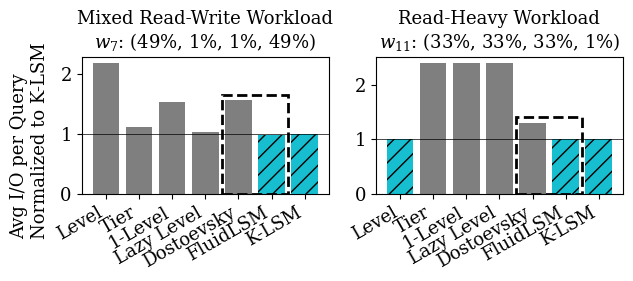

In [25]:
set_style(fsz=13)
fig, axes, xs = hist_plot([wls[7], wls[11]])
set_size(fig, width=2*3.33, height=1.5*2)
save_fig(fig, 'hist_nominal_wl.pdf')

In [21]:
#  for idx in range(0, len(wls), 2):
#     print(f'workloads {idx}, {idx+1}')
#     fig, axes, xs = hist_plot(wls[idx:idx+2])
#     set_size(fig, width=2*3.33, height=1.5*2)

In [22]:
(10 * config['system']['N']) / 8 / 1024 / 1024 / 1024

11.641532182693481

In [23]:
config['system']['M']

-1

In [ ]:
def hist_plot(workloads, plot_error=False):
    fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout=True)
    
    for idx, (workload, ax) in enumerate(zip(workloads, axes)):
        tunings = {model: get_nominal_tuning(workload, model) for model in models}
        w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
        wl_id = workload['id']
        z0, z1, q, w = w0
        xs = []
        base = eval_nominal('K-LSM', tunings['K-LSM'], z0, z1, q, w)
        for model, desc in tunings.items():
            xs.append(round(eval_nominal(model, desc, z0, z1, q, w) / base, 2))
        if wl_id == 11:
            colors = ['tab:cyan', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:cyan', 'tab:cyan']
            hatches = ['//', '', '', '', '', '//', '//']
        else:
            colors = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:cyan', 'tab:cyan']
            hatches = ['', '', '', '', '', '//', '//']
        ax.bar(models, xs, color=colors, hatch=hatches)
        ax.axhline(y=1, linestyle='-', linewidth=0.5, color='black')
        # ax.tick_params(rotation=80)
        fig.autofmt_xdate()
        if wl_id == 11:
            xlabel_str = 'Read-Heavy Workload\n'
        else:
            xlabel_str = 'Mixed Read-Write Workload\n'
        xlabel_str += f'$w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})'
        ax.set_title(xlabel_str)
        if wl_id == 11:
            rect = mpatches.Rectangle((3.5, 0), 2, 1.40, linewidth=2, color='black', fill=False, linestyle='--')
        else:
            rect = mpatches.Rectangle((3.5, 0), 2, 1.65, linewidth=2, color='black', fill=False, linestyle='--')
        ax.add_patch(rect)
        print(xs)
        # for key, val in tunings.items():
        #     print(f'{key}: {val["design"]}')
    
    # axes[0].set_xlabel(f'Model | $w_{{{wl_id}}}$: ({w0[0]:.0%}, {w0[1]:.0%}, {w0[2]:.0%}, {w0[3]:.0%})')
    fig.supylabel(f'Avg I/O per Query\nNormalized to K-LSM', x=0.05)
    return fig, axes, xs